# Logistic Regression with PyTorch

This is a simple example of using PyTorch to build a multinomial logistic regression model. To keep things simple I've avoided using any of the optimization (torch.optim) or data management (torch.utils.data) PyTorch features.

The data is generated by sampling from three Gaussian distributions (the label to predict is the identity of the distribution) with means $\mu \in \{-1,1\}^2$ and covariance $\Sigma = \frac{1}{2}I$.

In [1]:
%matplotlib inline
from __future__ import division, print_function
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import multivariate_normal as Normal
import torch
from torch import FloatTensor, LongTensor
from torch.nn import functional as F, Module, Parameter
from torch.autograd import Variable

## Sampling artificial data

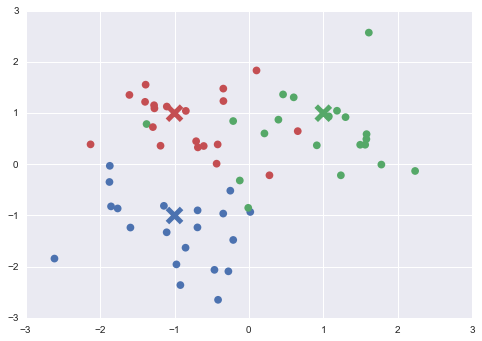

In [2]:
n_input = 2
n_labels = 3
n_samples_per_label = 20
n_samples = n_labels * n_samples_per_label
labels = range(n_labels)

# Sample means in {-1,1}^n_input
means = []
for k in labels:
    for i in range(30):
        mu = [1 if random.random() < 0.5 else -1 for i in range(n_input)]
        if mu not in means:
            means.append(mu)
            break
    else:
        raise ValueError('Could not sample {} labels'.format(n_labels))
means = np.vstack(means)

# Sample data
dists = {k: Normal(mu, np.eye(2) / 2) for k, mu in zip(labels, means)}
y = np.arange(n_samples) // n_samples_per_label
x = np.vstack([dists[k].rvs() for k in y])

# Visualize
colors = sns.color_palette()
plt.scatter(x[:,0], x[:,1], c=[colors[k] for k in y], s=60, lw=0)
plt.scatter(means[:,0], means[:,1], c=[colors[k] for k in labels], marker='x', s=200, lw=5)
x_np, y_np = x, y

## Multinomial logistic regression model definition

In [3]:
class Cat(Module):
    def __init__(self, n_input, n_output, scale=0.01):
        super(Cat, self).__init__()
        self.w = Parameter(scale * torch.randn(n_input, n_output))
        self.b = Parameter(torch.zeros((1, n_output)))
    
    def scores(self, x):
        return x.mm(self.w) + self.b.expand(x.size(0), self.b.size(1))
    
    def probs(self, x):
        return F.softmax(self.scores(x))
    
    def predict(self, x):
        return self.scores(x).data.numpy().argmax(1)
    
    def cost(self, x, y):
        return F.cross_entropy(self.scores(x), y)

mod = Cat(n_input, n_labels)
print('Model Parameters')
for name, param in mod._parameters.items():
    print(name, '=', param)

Model Parameters
w = Parameter containing:
1.00000e-02 *
  0.3840  1.6991  2.2605
 -1.1425 -0.1687 -0.2025
[torch.FloatTensor of size 2x3]

b = Parameter containing:
 0  0  0
[torch.FloatTensor of size 1x3]



## Parameter estimation

In [4]:
# Convert numpy arrays to torch tensors
y = LongTensor(y_np)
x = FloatTensor(x_np)

# Hyper parameters
batch_size = 10
lr = 0.01

# Fit
ix = np.arange(n_samples)
for epoch in range(0, 20):
    sum_nll = 0.0
    np.random.shuffle(ix)
    for b in range(0, n_samples, batch_size):
        # Setup mini-batches
        x_b = Variable(torch.cat([x[i].unsqueeze(0) for i in ix[b: b + batch_size]]))
        y_b = Variable(LongTensor([y[i] for i in ix[b: b + batch_size]]))
        mod.zero_grad()  # Need to zero fill gradients before running model 
        nll = mod.cost(x_b, y_b)
        sum_nll += float(nll.data.numpy())
        nll.backward()
        # Simple SGD for demo only, optimizers are in torch.optim 
        for param in mod.parameters():
            param.data.add_(-lr, param.grad.data)
    print('epoch:', epoch, 'nll:', sum_nll)

epoch: 0 nll: 6.48301541805
epoch: 1 nll: 6.30026721954
epoch: 2 nll: 6.12660849094
epoch: 3 nll: 5.96407359838
epoch: 4 nll: 5.81905597448
epoch: 5 nll: 5.67457848787
epoch: 6 nll: 5.53659361601
epoch: 7 nll: 5.409519732
epoch: 8 nll: 5.28958672285
epoch: 9 nll: 5.17588883638
epoch: 10 nll: 5.06994086504
epoch: 11 nll: 4.96653807163
epoch: 12 nll: 4.87107592821
epoch: 13 nll: 4.77956694365
epoch: 14 nll: 4.69354701042
epoch: 15 nll: 4.61155414581
epoch: 16 nll: 4.53442680836
epoch: 17 nll: 4.45927411318
epoch: 18 nll: 4.38820379972
epoch: 19 nll: 4.32047611475


## Inspection

Accuracy: 0.9


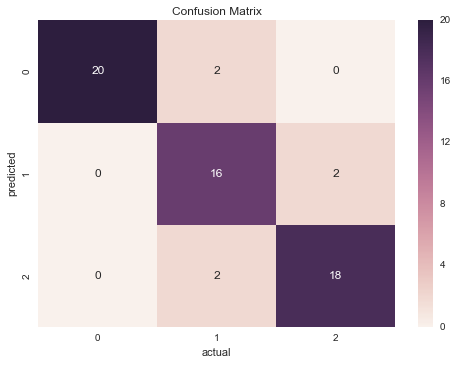

In [5]:
cmat = np.zeros((n_labels, n_labels))
mod.testing = True
y_pred = mod.predict(Variable(x, volatile=True))
for p, l in zip(y_pred, y_np):
    cmat[p, l] += 1
print('Accuracy:', cmat.diagonal().sum() / cmat.sum())
ax = plt.axes()
sns.heatmap(cmat, annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('actual')
ax.set_ylabel('predicted')

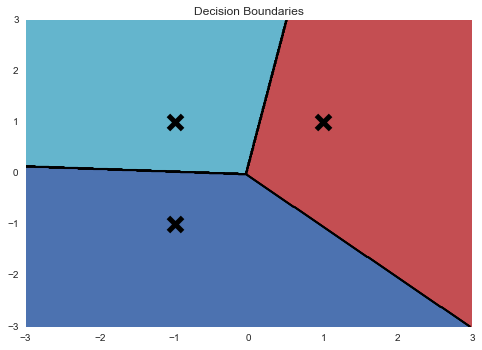

In [6]:
x1, x2 = np.meshgrid(np.arange(-3, 3, 0.01),
                     np.arange(-3, 3, 0.01))
y_pred = mod.predict(Variable(FloatTensor(np.c_[x1.ravel(), x2.ravel()]), volatile=True)).reshape(x1.shape)
ax = plt.axes()
ax.contour(x1, x2, y_pred, colors='k')
ax.contourf(x1, x2, y_pred, cmap=ListedColormap(sns.color_palette()))
ax.scatter(means[:,0], means[:,1], c='k', marker='x', s=200, lw=5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_title('Decision Boundaries')